# SVM Classifier (BERT-Boosted) x Toxic Content Detection
Il presente Notebook mostra l'addestramento ed il testing di un Classificatore basato su SVM per il task di Toxic Content Detection.

I dati sono stati processati come segue:
1. Pulizia del testo (si veda 'dataset_preprocessing.py')
2. Estrazione delle Features mediante BERT (si veda 'feature_extraction_bert_windows.ipynb'/'feature_extraction_bert_mac.ipynb')


In [3]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
import torch
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

e:\anaconda3\envs\DLProjectCUDA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All'interno del Notebook sarà addestrato un Classificatore LinearSVM.

## Funzioni di Supporto

In [5]:
# Carica il tokenizer e il modello preaddestrato di BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [6]:
# Definizione di una funzione per estrarre le caratteristiche di un testo utilizzando BERT
def extract_features(strings):
    # return_tensors ritorna il tensore per la versione pytorch
    # padding = true fa in modo che frasi di lunghezza diversa vengono portate alla lunghezza massima
    inputs = tokenizer(strings, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    #rappresentazione media e unidimensionale delle caratteristiche estratte
    features = torch.mean(last_hidden_states, dim=1).squeeze()
    features = features.numpy()
    return pd.DataFrame(features)

# LinearSVM

## Addestramento

In [7]:
training_set = pd.read_csv("./../../datasets/training_set.csv")
print("Numero di Frasi nel Training Set:", len(training_set))
print("Numero Frasi 'toxic' nel Training Set:", len(training_set[training_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Training Set:", len(training_set[training_set['toxic'] == 0]))

Numero di Frasi nel Training Set: 15282
Numero Frasi 'toxic' nel Training Set: 3058
Numero Frasi 'not-toxic' nel Training Set: 12224


In [8]:
y_train = training_set['toxic']

In [9]:
X_train = pd.read_csv("./../../datasets/X_train_bert.csv")
print("X_train.shape", X_train.shape)

X_train.shape (15282, 768)


In [10]:
cl = SVC(kernel='linear', probability=True, random_state=24)
model_filename = "linear_svm_classifier.pkl"

In [11]:
# Addestramento sul Dataset non-lemmatizzato
print("Training di LinearSVM sul Dataset elaborato con BERT...")
start = datetime.now()
cl.fit(X=X_train, y=y_train)
end = datetime.now()
print("Training completato! Tempo impiegato: " + str(end-start))

with open(model_filename, 'wb') as f:
    pickle.dump(cl, f)

Training di LinearSVM sul Dataset elaborato con BERT...
Training completato! Tempo impiegato: 0:01:54.332787


In [ ]:
# Caricamento del Modello pre-addestrato
with open(model_filename, 'rb') as f:
    cl = pickle.load(f)

## Testing

In [12]:
test_data = pd.read_csv("./../../datasets/test_set.csv")
test_data.dropna(inplace=True)

test_set = test_data[test_data['toxic'] != -1]
exp_set = test_data[test_data['toxic'] == -1]

print("Numero di Frasi nel Test Set:", len(test_set))
print("Numero Frasi 'toxic' nel Test Set:", len(test_set[test_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Test Set:", len(test_set[test_set['toxic'] == 0]))

Numero di Frasi nel Test Set: 63842
Numero Frasi 'toxic' nel Test Set: 6087
Numero Frasi 'not-toxic' nel Test Set: 57755


In [13]:
X_test = pd.read_csv("./../../datasets/X_test_bert.csv")
print("X_test.shape:", X_test.shape)
y_test = test_set['toxic']

X_test.shape: (63842, 768)


In [14]:
y_pred = cl.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F-Measure: " + str(f1_score(y_test, y_pred)))

Accuracy: 0.8988753485166505
Precision: 0.48098134212967736
Recall: 0.7665516674880893
F-Measure: 0.5910818343045351


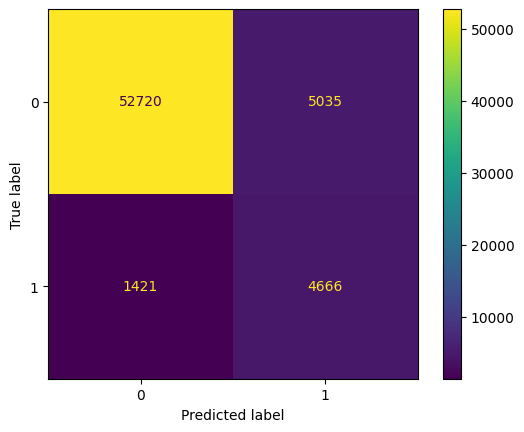

In [15]:
cm = confusion_matrix(y_test, y_pred, labels=cl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cl.classes_)
disp.plot()
plt.show()